In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet

In [5]:
verifications = pd.read_csv('verifications.csv')
identifiable = pd.read_csv('identifiable.csv')

In [7]:
identifiable.head()

,day,identifiable_users,logged_in_users,logged_out_unique_platform_users,logged_in_unique_platform_users,total_viewers,pct_identifiable,ds,y
0,2017-07-01,7498625,3358601,915267,3224757,11228837,0.667801,2017-07-01,7498625
1,2017-07-02,7736972,3488605,925338,3323029,11807065,0.655283,2017-07-02,7736972
2,2017-07-03,7364399,3331599,822585,3210215,10811353,0.681173,2017-07-03,7364399
3,2017-07-04,7503678,3340335,865984,3297359,11073959,0.677597,2017-07-04,7503678
4,2017-07-05,7746830,3459426,848711,3438693,11820461,0.655375,2017-07-05,7746830


In [6]:
verifications.head()

,day,platform,num_verifications
0,2017-10-15 00:00:00,ios,7991
1,2018-05-19 00:00:00,android,17080
2,2017-11-02 00:00:00,android,9025
3,2018-09-07 00:00:00,ios,21839
4,2018-04-08 00:00:00,ios,24686


In [135]:
def prophet_forecast(df, date_col, observation_col, periods=60, 
                     seasonality='additive', floor=None, cap=None, growth='linear'):
    
    df.loc[:, 'ds'] = pd.to_datetime(df[date_col])
    df.loc[:, 'y'] = df[observation_col].astype('int64')
    df.loc[:, 'floor'] = floor
    df.loc[:, 'cap'] = cap
    cols = ['ds', 'y']
    if floor:
        cols.extend(['floor','cap'])
    m = df[cols]
    model = Prophet(
                     seasonality_mode=seasonality,
                     growth=growth,
                     changepoint_range=0.8,
                     changepoint_prior_scale=0.1,
                     #yearly_seasonality=True,
                     #daily_seasonality=True
                   ).fit(m)
    future = model.make_future_dataframe(periods=periods)
    
    if floor != None:
        future.loc[:, 'cap'] = cap
        future.loc[:, 'floor'] = floor
    
    forecast = model.predict(future)
    
    #plots = [model.plot(forecast), model.plot_components(forecast)]
    
    return model, forecast

In [38]:
model, forecast = prophet_forecast(
                       df=identifiable,
                       date_col='day',
                       observation_col='identifiable_users',
                       periods=100
)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [50]:
from prophet.plot import add_changepoints_to_plot, plot_cross_validation_metric

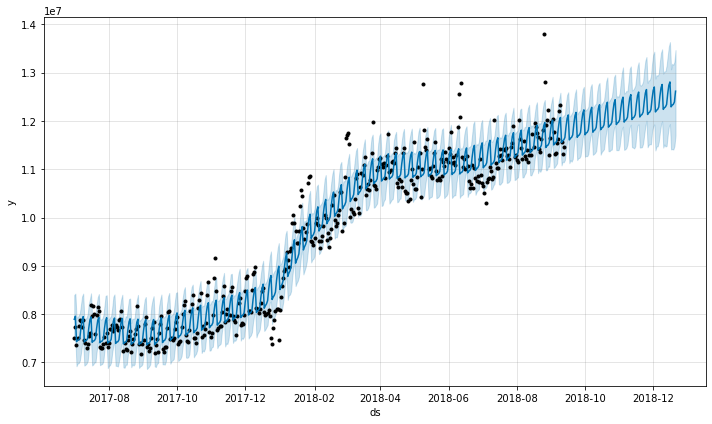

In [41]:
fig = model.plot(forecast)

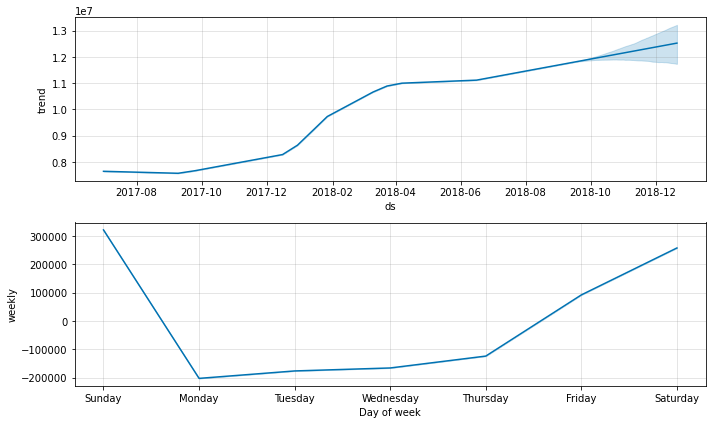

In [44]:
fig = model.plot_components(forecast, figsize=(10,6))

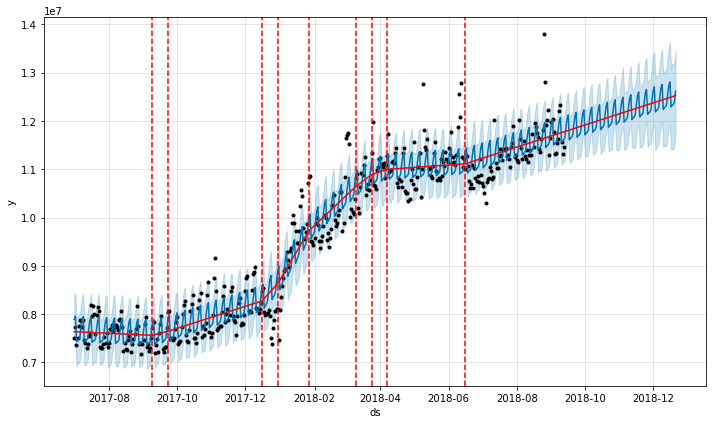

In [39]:
fig = model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model, forecast)

In [42]:
model.changepoints

14    2017-07-15
28    2017-07-29
42    2017-08-12
56    2017-08-26
70    2017-09-09
84    2017-09-23
98    2017-10-07
112   2017-10-21
126   2017-11-04
140   2017-11-18
154   2017-12-02
168   2017-12-16
182   2017-12-30
196   2018-01-13
210   2018-01-27
224   2018-02-10
238   2018-02-24
252   2018-03-10
266   2018-03-24
280   2018-04-07
294   2018-04-21
308   2018-05-05
322   2018-05-19
336   2018-06-02
350   2018-06-16
Name: ds, dtype: datetime64[ns]

In [49]:
from prophet.diagnostics import cross_validation
cv = cross_validation(model, horizon=pd.to_timedelta(100, unit="D"))

INFO:prophet:Making 1 forecasts with cutoffs between 2018-06-04 00:00:00 and 2018-06-04 00:00:00


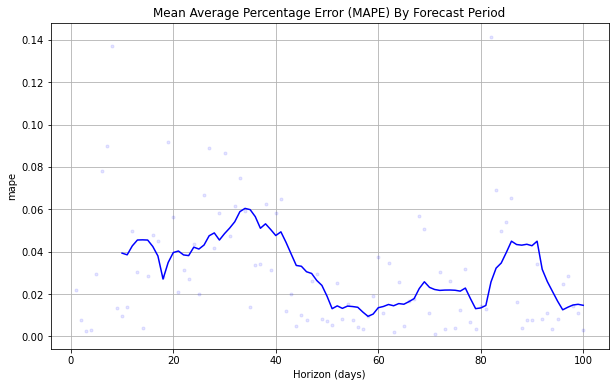

In [63]:
fig, ax = plt.subplots(figsize=(10,6))
plot_cross_validation_metric(cv, metric='mape', ax=ax)
ax.set_title('Mean Average Percentage Error (MAPE) By Forecast Period');

In [61]:
model180, forecast180 = prophet_forecast(
    df=identifiable,
    date_col='day',
    observation_col='identifiable_users',
    periods=180
)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


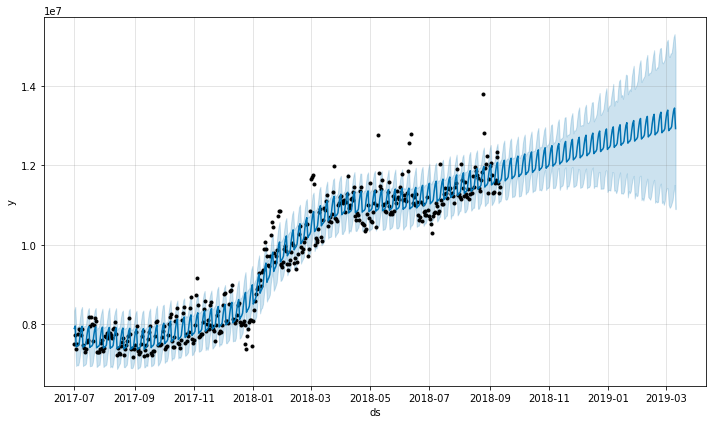

In [62]:
fig = model180.plot(forecast180)

In [84]:
trim = identifiable.query('day >= "2018-01-01"')
outliers = trim['identifiable_users'].mean() + 2 * trim['identifiable_users'].std() 

In [85]:
trimmed = identifiable.query('day > "2018-01-01" and identifiable_users <= @outliers')

In [86]:
trimmed

,day,identifiable_users,logged_in_users,logged_out_unique_platform_users,logged_in_unique_platform_users,total_viewers,pct_identifiable,ds,y,floor,cap
185,2018-01-02,8357795.0,3708592,234137,4415066,12532615,0.666884,2018-01-02,8357795,None,None
186,2018-01-03,8591379.0,3825982,237825,4527572,13095277,0.656067,2018-01-03,8591379,None,None
187,2018-01-04,8754963.0,3874144,246563,4634256,13335939,0.656494,2018-01-04,8754963,None,None
188,2018-01-05,8893556.0,3940689,256985,4695882,13761294,0.646273,2018-01-05,8893556,None,None
189,2018-01-06,8924955.0,3938648,266801,4719506,13723945,0.650320,2018-01-06,8924955,None,None
...,...,...,...,...,...,...,...,...,...,...,...
434,2018-09-08,12213926.0,4824681,353571,7035674,21465148,0.569012,2018-09-08,12213926,None,None
435,2018-09-09,12332222.0,4941037,330651,7060534,22846008,0.539798,2018-09-09,12332222,None,None
436,2018-09-10,11556004.0,4594027,288516,6673461,18652456,0.619543,2018-09-10,11556004,None,None
437,2018-09-11,11305901.0,4600477,282357,6423067,19167440,0.589849,2018-09-11,11305901,None,None


In [96]:
model180_trim, forecast180_trim = prophet_forecast(
    df=trimmed,
    date_col='day',
    observation_col='identifiable_users',
    periods=180
)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


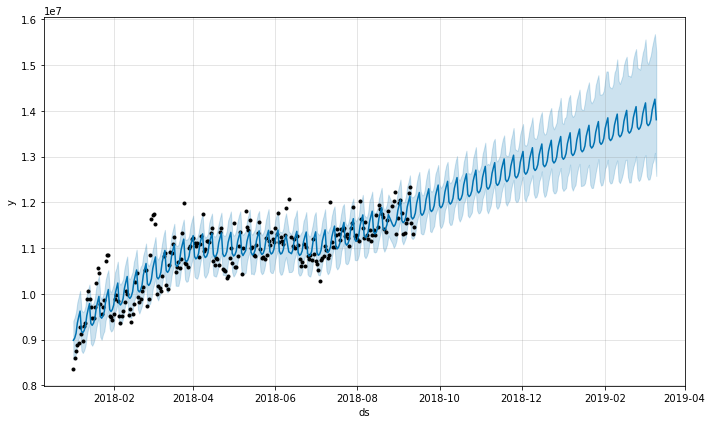

In [90]:
fig = model180_trim.plot(forecast180_trim)

In [136]:
verify_android_post_model, verify_android_post_forecast = prophet_forecast(
    df=verifications.query('platform == "android"'),
    date_col='day',
    observation_col='num_verifications',
    periods=100, floor=1000, cap=100000,
    growth='logistic')

verify_android_pre_model, verify_android_pre_forecast = prophet_forecast(
    df=verifications.query('platform == "android" & day < "2018-07-17"'),
    date_col='day',
    observation_col='num_verifications',
    periods=100, floor=1000, cap=100000,
    growth='logistic')

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


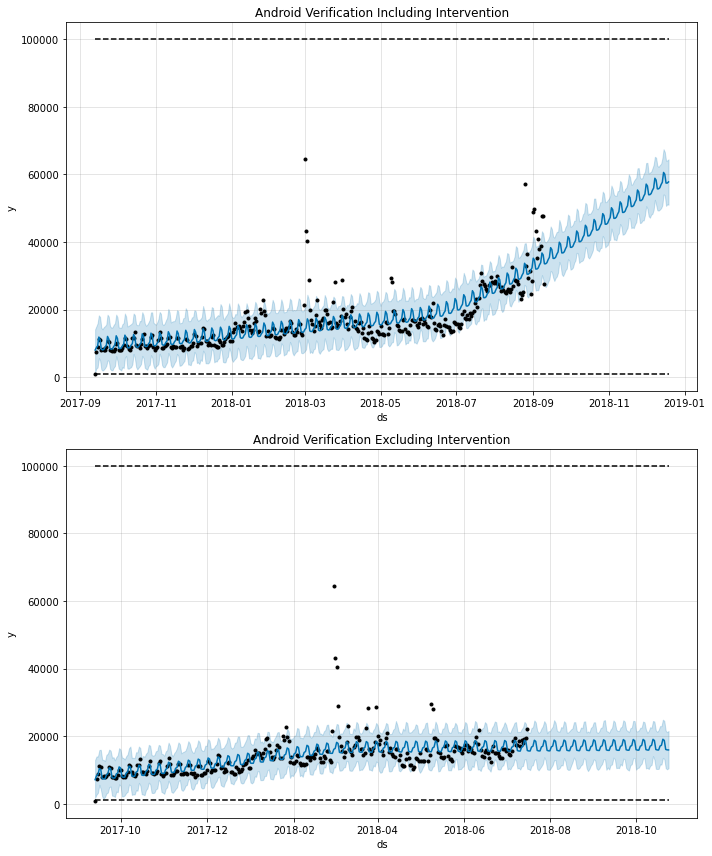

In [137]:
fig, ax = plt.subplots(2, 1, figsize=(10,12))
verify_android_post_model.plot(verify_android_post_forecast, ax=ax[0])
verify_android_pre_model.plot(verify_android_pre_forecast, ax=ax[1])

ax[0].set_title('Android Verification Including Intervention')
ax[1].set_title('Android Verification Excluding Intervention')
plt.tight_layout();